In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation
import PIL
from PIL import Image
import random
import os



In [13]:
random.seed(0)
data_main = pd.read_csv('data_labels_mainData.csv')
data_main.drop(columns=["InstanceID", "patientID"])
data_extra = pd.read_csv('data_labels_extraData.csv')
data_extra.drop(columns=["InstanceID", "patientID"])


,ImageName,isCancerous
0,12681.png,0
1,12682.png,0
2,12683.png,0
3,12684.png,0
4,12685.png,0
...,...,...
10379,20028.png,0
10380,20029.png,0
10381,20030.png,0
10382,20031.png,0


Main Data Shape: (9896, 6)
Extra Data Shape: (10384, 4)
Common Columns: 
      InstanceID
      patientID
      ImageName
      isCancerous
Unique Main Columns: 
      cellType
      cellTypeName
Null Main Data: InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64
Duplicated Main Data: 0
Images Duplicated:  0
Value counts for Iscancerous
isCancerous
0    5817
1    4079
Name: count, dtype: int64
Percent size: 
0: 58.78132578819725
1: 41.21867421180275


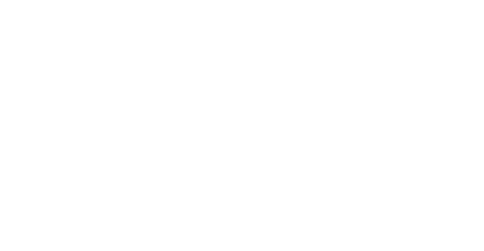

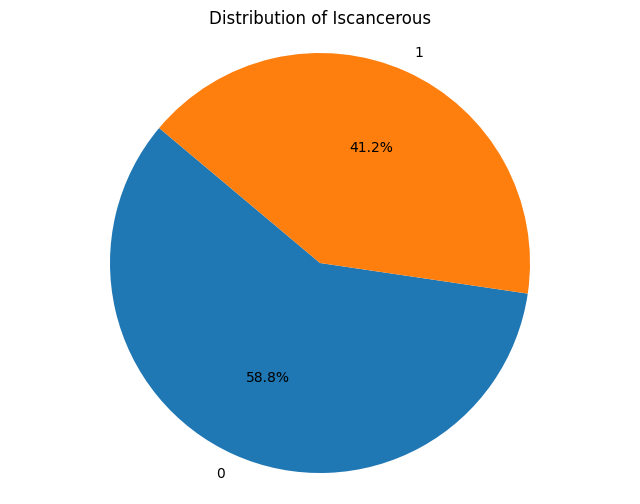

Value counts for Celltypename
cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: count, dtype: int64
Percent size: 
Epithelial: 41.21867421180275
Inflammatory: 25.697251414713012
Fibroblast: 19.078415521422798
Others: 14.005658852061439


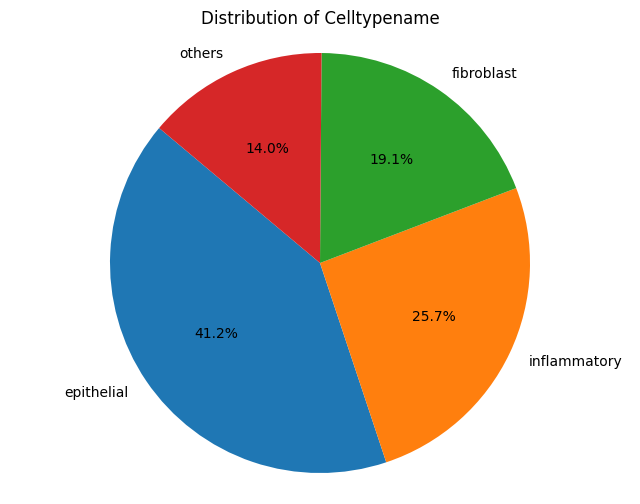

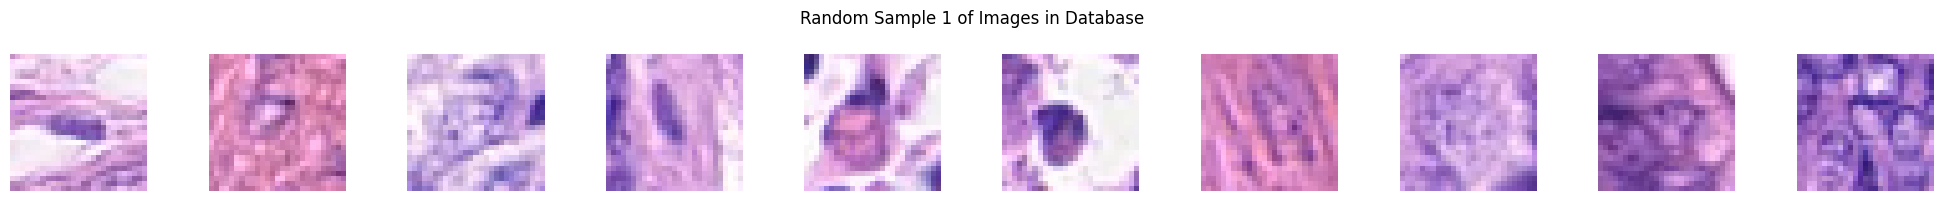

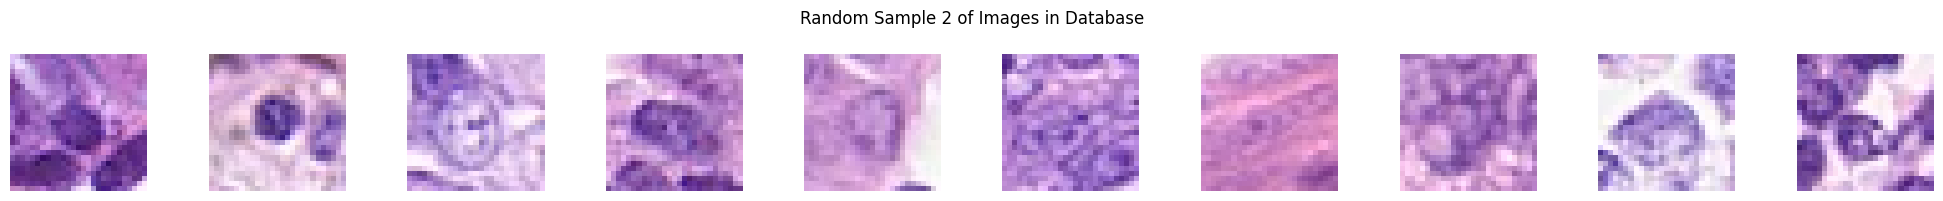

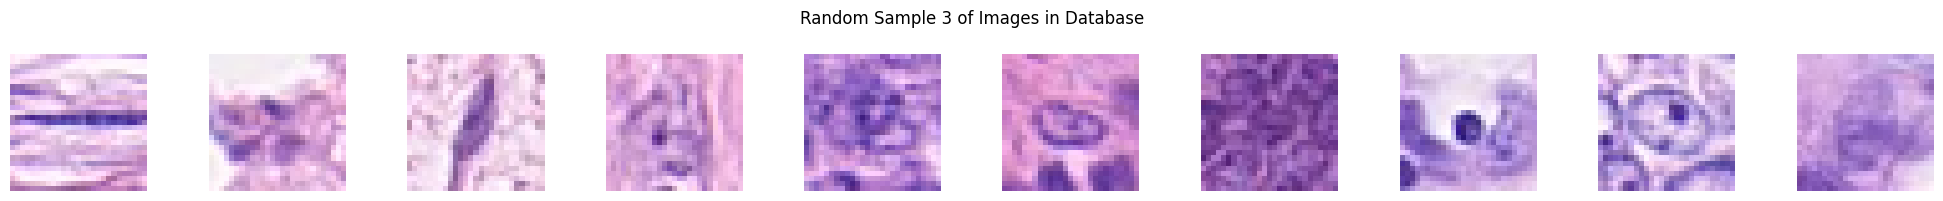

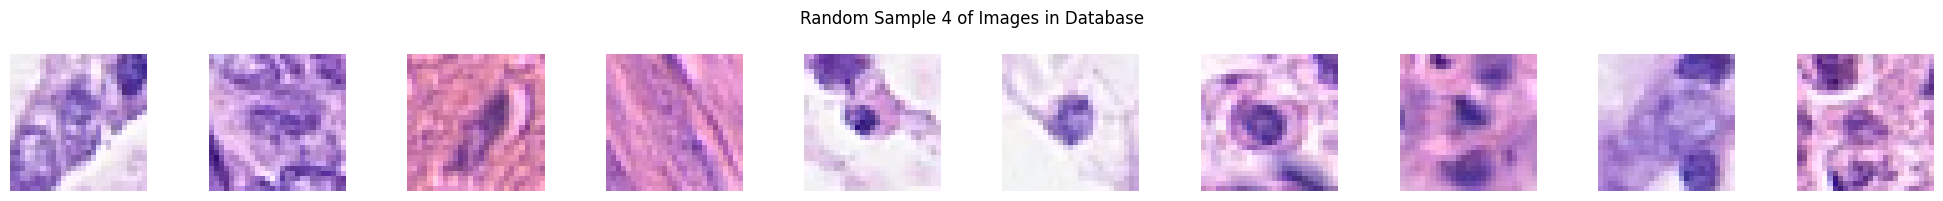

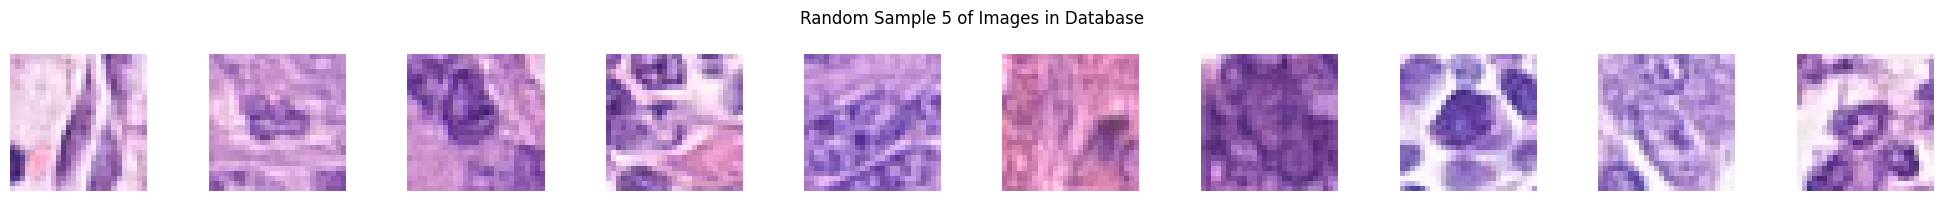

In [14]:
#EDA
fig, ax = plt.subplots(figsize=(6,3))
ax.axis("off")

#Structure and Size
print("Main Data Shape: " + str(data_main.shape))
print("Extra Data Shape: " + str(data_extra.shape))
print("Common Columns: ")

for column in data_main.columns.intersection(data_extra.columns):
    print("      "+ column)
print("Unique Main Columns: ")
for column in data_main.columns.symmetric_difference(data_extra.columns):
    print("      "+ column)

print("Null Main Data: " + str(data_main.isnull().sum()))
print("Duplicated Main Data: " + str(data_main.duplicated().sum()))
print("Images Duplicated:  " + str(data_main["ImageName"].duplicated().sum()))

#Value Counts
relevantColumns = ["isCancerous", "cellTypeName"]
for col in relevantColumns:
    print(f"Value counts for " + col.capitalize())
    value_counts = data_main[col].value_counts()
    print(value_counts)
    print("Percent size: " )
    
    for value, amount in data_main[col].value_counts().items():
        print(str(value).capitalize() + ": " + str((amount/len(data_main[col]))*100))
    
    plt.figure(figsize=(8, 6))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f"Distribution of {col.capitalize()}")
    plt.axis('equal')  
    plt.show()

pd.crosstab(data_main["cellTypeName"], data_main["isCancerous"])

#Random Sampling
dir = "./patch_images/" 
for i in range(1, 6):
    fig, axes = plt.subplots(1, 10, figsize=(20,2))
    fig.suptitle("Random Sample " + str(i) + " of Images in Database")
    sampledRows = data_main.sample(10)
    for j, ax in enumerate(axes):
        image_name = sampledRows.iloc[j]["ImageName"]
        img = np.asarray(Image.open(dir + image_name))
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


In [73]:
data_cancer = data_main.drop(columns=["cellTypeName", "cellType"])
data_cancer = pd.concat([data_cancer, data_extra])

IMG_SIZE = 27
cell_type_counts = data_main["cellType"].value_counts().sort_index()
most_common_cell_type = cell_type_counts.idxmax()
print(most_common_cell_type)
max_value = cell_type_counts.max()
print(max_value)

cell_type_mapping = data_main.drop_duplicates(subset=["cellType"])[["cellType", "cellTypeName"]].sort_values("cellType")
cell_type_names = cell_type_mapping["cellTypeName"].values
cell_type_dict = dict(zip(cell_type_mapping["cellType"], cell_type_mapping["cellTypeName"]))
print(cell_type_dict)


cellType0Images = data_main[data_main["cellType"] == 0]["ImageName"].values
cellType1Images = data_main[data_main["cellType"] == 1]["ImageName"].values
cellType2Images = data_main[data_main["cellType"] == 2]["ImageName"].values
cellType3Images = data_main[data_main["cellType"] == 3]["ImageName"].values

imageCollections = []
imageCollections.append(cellType0Images)
imageCollections.append(cellType1Images)
imageCollections.append(cellType2Images)
imageCollections.append(cellType3Images)

data_type = data_main.drop(columns=["cellTypeName", "isCancerous"])
data_type_with_augmentation = data_type.copy()
cell_types_to_generate = cell_type_dict.copy()
del cell_types_to_generate[most_common_cell_type]
print(cell_types_to_generate)
dir = "./patch_images/"
for i, cellType in enumerate(cell_types_to_generate):
    cellTypeName = cell_type_dict[cellType]
    augDir = dir + "augmented_images/" + cellTypeName + "/"
    existing_aug = [name for name in os.listdir(augDir) if os.path.isfile(os.path.join(augDir, name))]
    print(len(existing_aug) + len(imageCollections[i]))
    print(max_value)
    if not len(existing_aug) + len(imageCollections[i]) >= max_value:
        augmented_df = AugmentData(imageCollections[i], max_value, data_type, i, cell_type_dict[i])
        data_type_with_augmentation = pd.concat([data_type_with_augmentation, augmented_df], ignore_index=True)


2
4079
{0: 'fibroblast', 1: 'inflammatory', 2: 'epithelial', 3: 'others'}
{0: 'fibroblast', 1: 'inflammatory', 3: 'others'}
4079
4079
4079
4079
6772
4079


In [16]:

def AugmentData(imageNames ,maxCount, originalDF, label, labelName):
    
    counter = len(imageNames)

    augmentedRows = []
    
    dir = "./patch_images/"
    augDir = dir + "augmented_images/" + labelName + "/"
    existing_aug = [name for name in os.listdir(augDir) if os.path.isfile(os.path.join(augDir, name))]
    existing_aug_count = len(existing_aug)
    counter += existing_aug_count
    print("Number of Files Detected: " + str(counter) + "Max Count: " + str(maxCount))
    if(counter >= maxCount):
        return

    # #Empty the directory
    # for fileName in os.listdir(augDir):
    #     file_path = os.path.join(augDir, fileName)
    #     if(os.path.isfile(file_path)):
    #         os.remove(file_path)

    
    while counter < maxCount:
        counter += 1
        #Pick and random image and open
        chosenImage = imageNames[random.randint(0, len(imageNames)-1)]
        openedImage = PIL.Image.open(dir + chosenImage).convert("RGB")
       
        #convert to data 
        image_np = np.array(openedImage)
        image_tensor = tf.convert_to_tensor(image_np, dtype=tf.float32)
        image_tensor = tf.expand_dims(image_tensor, 0)  # Add batch dimension
        
        data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        ])
        augmented_tensor = data_augmentation(image_tensor)
        augmented_image = tf.cast(tf.squeeze(augmented_tensor), tf.uint8).numpy()
        augmented_pil = PIL.Image.fromarray(augmented_image)

        augmentedImageName = "Augmented" + str(counter) +".png"
        save_path = os.path.join(augDir + augmentedImageName)
        augmented_pil.save(save_path)
        new_row = {"ImageName": augmentedImageName, "cellType": label, "cellTypeName": labelName}
        augmentedRows.append(new_row)
    
    return pd.DataFrame(augmentedRows)

In [17]:
train_data_cancer, test_data_cancer = train_test_split(data_cancer, test_size=0.2, random_state=42)
train_data_cancer, val_data_cancer = train_test_split(train_data_cancer, test_size=0.25, random_state=42)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

earlyStop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=5, verbose=1, mode='max', restore_best_weights=True)

**MLP**

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='sigmoid'),
    tf.keras.layers.Dense(2)
])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560,642 (2.14 MB)

 Trainable params: 560,642 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [22]:
train_data_cancer['isCancerous'] = train_data_cancer['isCancerous'].astype('str')
val_data_cancer['isCancerous'] = val_data_cancer['isCancerous'].astype('str')

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

print(train_generator)
print(validation_generator)

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


In [24]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50


C:\Users\Harrison007\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


451/451 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - categorical_accuracy: 0.6778 - loss: 0.6006 - val_categorical_accuracy: 0.8316 - val_loss: 0.5024
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - categorical_accuracy: 0.7898 - loss: 0.4762 - val_categorical_accuracy: 0.8247 - val_loss: 0.4079
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - categorical_accuracy: 0.8271 - loss: 0.4048 - val_categorical_accuracy: 0.8385 - val_loss: 0.3758
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - categorical_accuracy: 0.8292 - loss: 0.3906 - val_categorical_accuracy: 0.8257 - val_loss: 0.3962
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - categorical_accuracy: 0.8275 - loss: 0.3809 - val_categorical_accuracy: 0.7981 - val_loss: 0.4358
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - categorical_accuracy: 0.8359 - loss: 0.3718 - val_categorical_accuracy: 0.8417 - val_loss: 0.3619
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - categorical_accuracy: 0.8391 - loss: 

Early stopping is triggered at epoch 10 with the best weights being found at epoch 7 meaning running it for longer either will make results worse or have no impact

In [25]:
def plot_learning_curve(title, train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

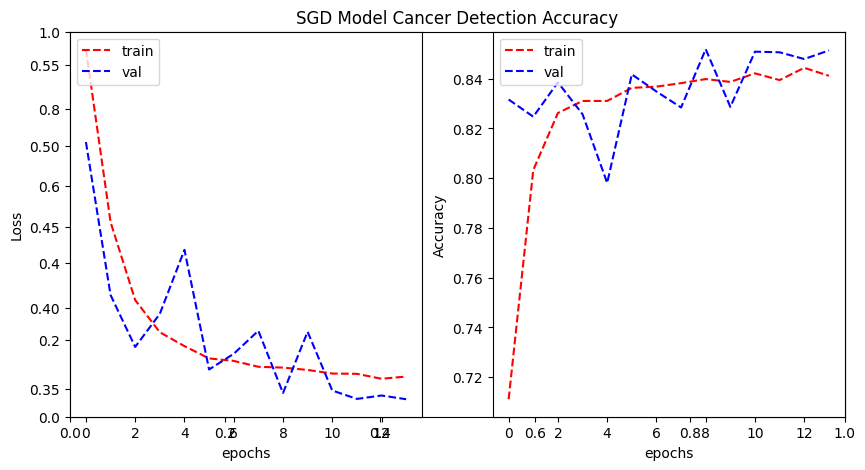

In [26]:
plot_learning_curve("SGD Model Cancer Detection Accuracy",history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [27]:
test_data_cancer['isCancerous'] = test_data_cancer['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_cancer,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 4056 validated image filenames belonging to 2 classes.


In [28]:
model.evaluate(test_generator)

  42/4056 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - categorical_accuracy: 0.6412 - loss: 0.5614     

C:\Users\Harrison007\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4056/4056 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - categorical_accuracy: 0.8485 - loss: 0.3532


[0.34939342737197876, 0.8518244624137878]

**CNN**

In [29]:
model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(2),
])

C:\Users\Harrison007\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [31]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - categorical_accuracy: 0.6290 - loss: 0.6787 - val_categorical_accuracy: 0.6573 - val_loss: 0.6446
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - categorical_accuracy: 0.6548 - loss: 0.6472 - val_categorical_accuracy: 0.6573 - val_loss: 0.6454
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - categorical_accuracy: 0.6539 - loss: 0.6481 - val_categorical_accuracy: 0.6573 - val_loss: 0.6456
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - categorical_accuracy: 0.6506 - loss: 0.6494 - val_categorical_accuracy: 0.6573 - val_loss: 0.6519
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - categorical_accuracy: 0.6486 - loss: 0.6520 - val_categorical_accuracy: 0.6573 - val_loss: 0.6453
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - categorical_accuracy: 0.6524 - loss: 0.6491 - val_categorical_accuracy: 0.6573 - val_loss: 0.6429
Epoch 6: early stopping
Restoring model weights from the end of the best epo

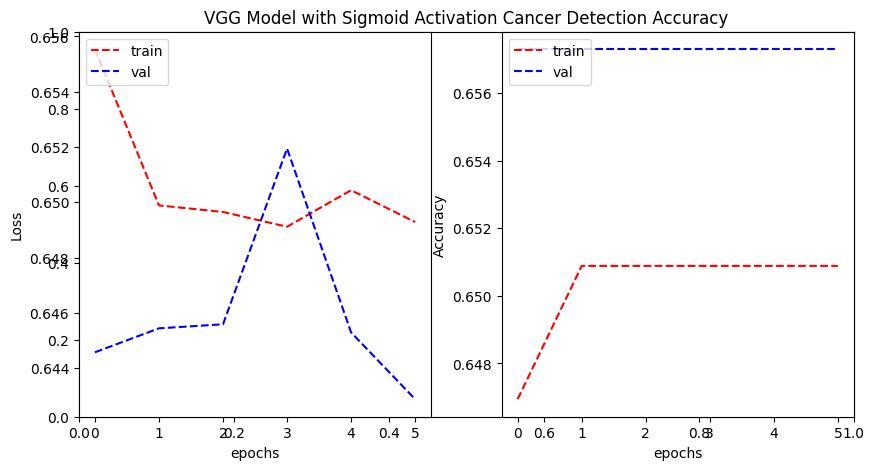

In [32]:
plot_learning_curve("VGG Model with Sigmoid Activation Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [33]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - categorical_accuracy: 0.6423 - loss: 0.6525


[0.6499231457710266, 0.6471893787384033]

After doing some research, using sigmoid for the hidden layers can lead to learning stopping really early which is exactly what this looks like

In [34]:
model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(2),
])

In [35]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [36]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - categorical_accuracy: 0.6664 - loss: 0.6217 - val_categorical_accuracy: 0.8639 - val_loss: 0.3290
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - categorical_accuracy: 0.8566 - loss: 0.3415 - val_categorical_accuracy: 0.8439 - val_loss: 0.3647
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - categorical_accuracy: 0.8616 - loss: 0.3289 - val_categorical_accuracy: 0.8595 - val_loss: 0.3331
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - categorical_accuracy: 0.8858 - loss: 0.2822 - val_categorical_accuracy: 0.8775 - val_loss: 0.3010
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - categorical_accuracy: 0.8815 - loss: 0.2932 - val_categorical_accuracy: 0.8508 - val_loss: 0.3429
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - categorical_accuracy: 0.8785 - loss: 0.2874 - val_categorical_accuracy: 0.8691 - val_loss: 0.3090
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - categorical_accuracy

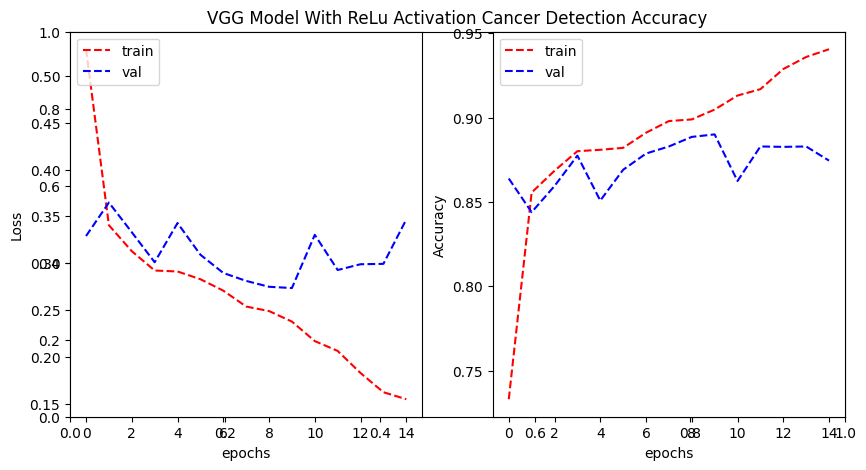

In [37]:
plot_learning_curve("VGG Model With ReLu Activation Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [38]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - categorical_accuracy: 0.8902 - loss: 0.2633


[0.2720385193824768, 0.8865877985954285]

Now it is clearly overfitting so we can start by simplifying the model as the images are relatively simple

In [39]:
model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(2),
])

In [40]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [41]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - categorical_accuracy: 0.7526 - loss: 0.4971 - val_categorical_accuracy: 0.8590 - val_loss: 0.3305
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - categorical_accuracy: 0.8520 - loss: 0.3391 - val_categorical_accuracy: 0.8787 - val_loss: 0.2860
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - categorical_accuracy: 0.8684 - loss: 0.3153 - val_categorical_accuracy: 0.8225 - val_loss: 0.4118
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - categorical_accuracy: 0.8762 - loss: 0.2963 - val_categorical_accuracy: 0.8856 - val_loss: 0.2777
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - categorical_accuracy: 0.8862 - loss: 0.2832 - val_categorical_accuracy: 0.8809 - val_loss: 0.2863
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - categorical_accuracy: 0.8921 - loss: 0.2585 - val_categorical_accuracy: 0.8568 - val_loss: 0.3323
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - categorical_accuracy: 0.89

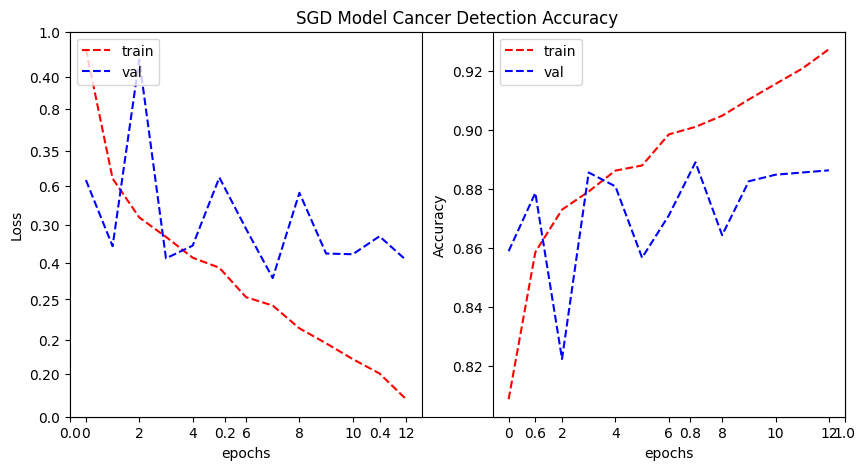

In [42]:
plot_learning_curve("SGD Model Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [43]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - categorical_accuracy: 0.8984 - loss: 0.2459


[0.2535671889781952, 0.8934911489486694]

The model is still overfitting but less so, now we can try regularisation

In [44]:
from tensorflow.keras import regularizers
model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(2),
])

In [45]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [46]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - categorical_accuracy: 0.7114 - loss: 0.6411 - val_categorical_accuracy: 0.8538 - val_loss: 0.3758
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - categorical_accuracy: 0.8397 - loss: 0.4067 - val_categorical_accuracy: 0.8691 - val_loss: 0.3538
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - categorical_accuracy: 0.8575 - loss: 0.3749 - val_categorical_accuracy: 0.8614 - val_loss: 0.3631
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - categorical_accuracy: 0.8629 - loss: 0.3572 - val_categorical_accuracy: 0.8772 - val_loss: 0.3354
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - categorical_accuracy: 0.8731 - loss: 0.3442 - val_categorical_accuracy: 0.8624 - val_loss: 0.3501
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - categorical_accuracy: 0.8715 - loss: 0.3438 - val_categorical_accuracy: 0.8688 - val_loss: 0.3434
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - categorical_accuracy: 0.87

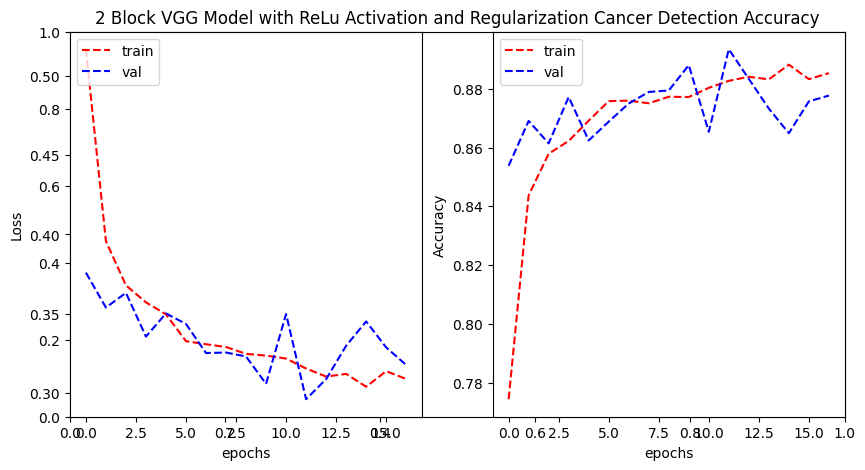

In [47]:
plot_learning_curve("2 Block VGG Model with ReLu Activation and Regularization Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [48]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - categorical_accuracy: 0.8905 - loss: 0.2915


[0.29273244738578796, 0.8888067007064819]

This very clearly has worked so now we can try to add back the other hidden block and see if the model can handle it now or if it still is too complex for the task

In [49]:

model_VGG_cancerous = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(2),
])

In [50]:
model_VGG_cancerous.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [51]:
history_vgg_cancerous = model_VGG_cancerous.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - categorical_accuracy: 0.7128 - loss: 0.7454 - val_categorical_accuracy: 0.8649 - val_loss: 0.3848
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - categorical_accuracy: 0.8408 - loss: 0.4193 - val_categorical_accuracy: 0.8459 - val_loss: 0.3981
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - categorical_accuracy: 0.8614 - loss: 0.3764 - val_categorical_accuracy: 0.8585 - val_loss: 0.3596
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - categorical_accuracy: 0.8671 - loss: 0.3632 - val_categorical_accuracy: 0.8432 - val_loss: 0.3974
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - categorical_accuracy: 0.8791 - loss: 0.3377 - val_categorical_accuracy: 0.8826 - val_loss: 0.3205
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - categorical_accuracy: 0.8719 - loss: 0.3462 - val_categorical_accuracy: 0.8723 - val_loss: 0.3366
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - categorical_accuracy

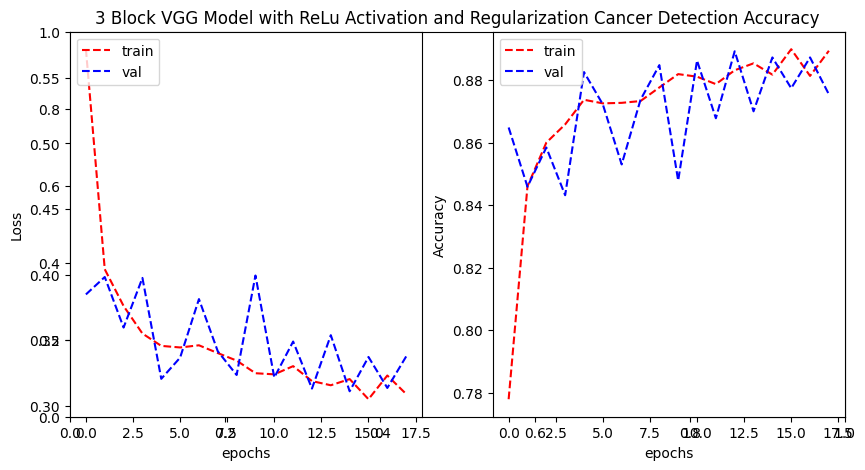

In [52]:
plot_learning_curve("3 Block VGG Model with ReLu Activation and Regularization Cancer Detection Accuracy",history_vgg_cancerous.history['loss'], history_vgg_cancerous.history['val_loss'], 
                    history_vgg_cancerous.history['categorical_accuracy'], history_vgg_cancerous.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [53]:
model_VGG_cancerous.evaluate(test_generator)

4056/4056 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - categorical_accuracy: 0.8974 - loss: 0.2943


[0.30362579226493835, 0.8910256624221802]

In [54]:
#Classification
data_type = data_main.drop(columns=["cellTypeName", "isCancerous"])
print(data_type)

      InstanceID  patientID  ImageName  cellType
0          22405          1  22405.png         0
1          22406          1  22406.png         0
2          22407          1  22407.png         0
3          22408          1  22408.png         0
4          22409          1  22409.png         0
...          ...        ...        ...       ...
9891        1625         60   1625.png         2
9892        1626         60   1626.png         2
9893        1627         60   1627.png         2
9894        1628         60   1628.png         2
9895        1629         60   1629.png         2

[9896 rows x 4 columns]


In [55]:
train_data_type, test_data_type = train_test_split(data_type, test_size=0.2, random_state=42)
train_data_type, val_data_type = train_test_split(train_data_type, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_type.shape[0], val_data_type.shape[0], test_data_type.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [56]:
train_data_type['cellType'] = train_data_type['cellType'].astype('str')
val_data_type['cellType'] = val_data_type['cellType'].astype('str')

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data_type,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data_type,
        directory="./patch_images/",
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [57]:
model_VGG_1_relu = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4),
])

model_VGG_1_sigmoid = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(4),
])

model_VGG_1_softmax = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='softmax', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='softmax', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='softmax'),
    tf.keras.layers.Dense(4),
])

C:\Users\Harrison007\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
model_VGG_1_relu.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
model_VGG_1_sigmoid.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
model_VGG_1_softmax.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


In [59]:
history_VGG_1_relu = model_VGG_1_relu.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)
history_VGG_1_sigmoid = model_VGG_1_sigmoid.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)
history_VGG_1_softmax = model_VGG_1_softmax.fit(train_generator, validation_data = validation_generator, epochs=50, callbacks=earlyStop, verbose=1)

C:\Users\Harrison007\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - categorical_accuracy: 0.5205 - loss: 1.1155 - val_categorical_accuracy: 0.6508 - val_loss: 0.8276
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - categorical_accuracy: 0.6963 - loss: 0.7709 - val_categorical_accuracy: 0.6978 - val_loss: 0.7342
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - categorical_accuracy: 0.7242 - loss: 0.7101 - val_categorical_accuracy: 0.6801 - val_loss: 0.7831
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - categorical_accuracy: 0.7116 - loss: 0.7252 - val_categorical_accuracy: 0.7357 - val_loss: 0.6596
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - categorical_accuracy: 0.7436 - loss: 0.6539 - val_categorical_accuracy: 0.7610 - val_loss: 0.6212
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - categorical_accuracy: 0.7460 - loss: 0.6293 - val_categorical_accuracy: 0.7751 - val_loss: 0.6065
Epoch 7/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - categorical_accuracy: 0.766

In [60]:
test_data_type['cellType'] = test_data_type['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data_type,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


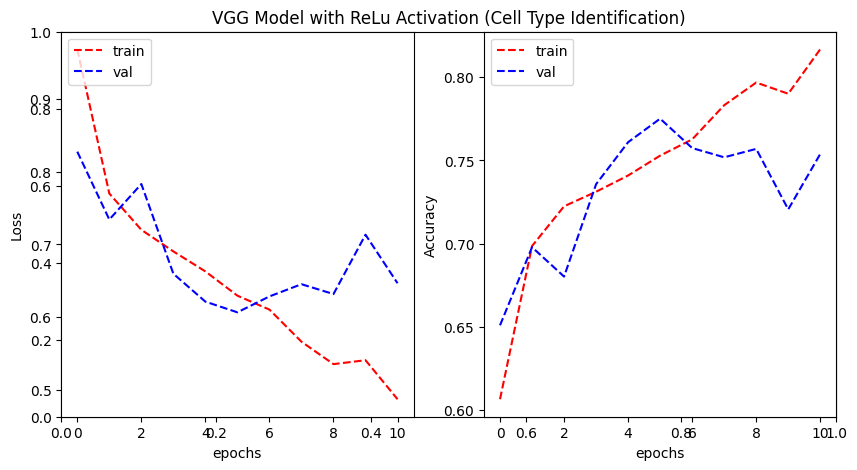

  30/1980 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - categorical_accuracy: 0.7080 - loss: 0.5376     

C:\Users\Harrison007\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1980/1980 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - categorical_accuracy: 0.7543 - loss: 0.6467


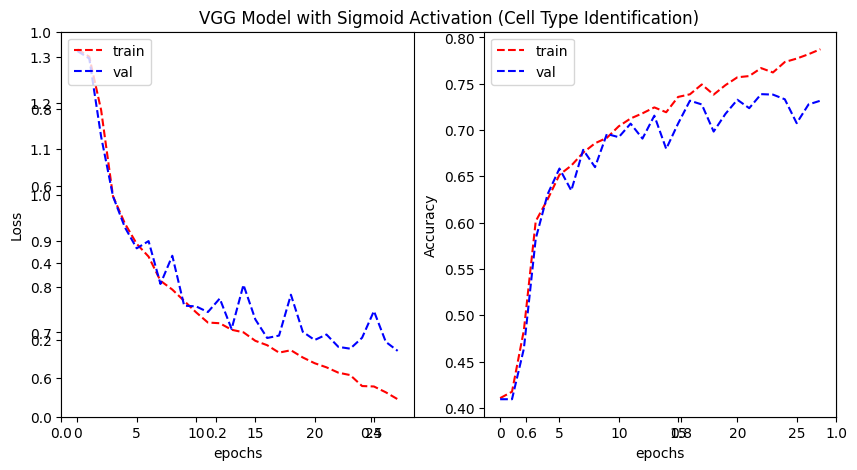

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - categorical_accuracy: 0.7138 - loss: 0.7291


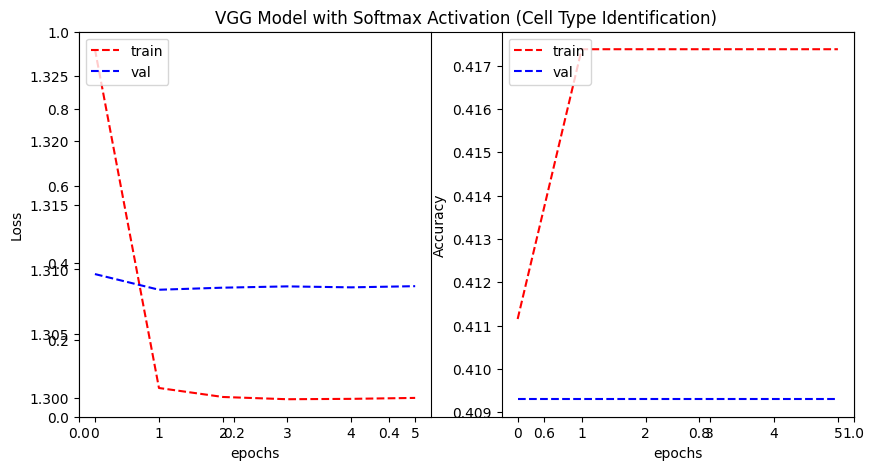

1980/1980 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - categorical_accuracy: 0.4113 - loss: 1.3132


[1.3208473920822144, 0.3994949460029602]

In [61]:
plot_learning_curve("VGG Model with ReLu Activation (Cell Type Identification)",history_VGG_1_relu.history['loss'], history_VGG_1_relu.history['val_loss'], 
                    history_VGG_1_relu.history['categorical_accuracy'], history_VGG_1_relu.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_relu.evaluate(test_generator)
plot_learning_curve("VGG Model with Sigmoid Activation (Cell Type Identification)",history_VGG_1_sigmoid.history['loss'], history_VGG_1_sigmoid.history['val_loss'], 
                    history_VGG_1_sigmoid.history['categorical_accuracy'], history_VGG_1_sigmoid.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_sigmoid.evaluate(test_generator)

plot_learning_curve("VGG Model with Softmax Activation (Cell Type Identification)",history_VGG_1_softmax.history['loss'], history_VGG_1_softmax.history['val_loss'], 
                    history_VGG_1_softmax.history['categorical_accuracy'], history_VGG_1_softmax.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

model_VGG_1_softmax.evaluate(test_generator)


This shows a significant amount of overfitting, due to the model learning valuing irrelevant features like noise resulting in worse performance with new data

In [62]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    # preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # preprocessing.RandomFlip("horizontal"),
    # preprocessing.RandomRotation(0.2),
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(4),
])

model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


C:\Users\Harrison007\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - categorical_accuracy: 0.4555 - loss: 1.3082 - val_categorical_accuracy: 0.6675 - val_loss: 0.9405
Epoch 2/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - categorical_accuracy: 0.6597 - loss: 0.9348 - val_categorical_accuracy: 0.6867 - val_loss: 0.8509
Epoch 3/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - categorical_accuracy: 0.6890 - loss: 0.8664 - val_categorical_accuracy: 0.6892 - val_loss: 0.8159
Epoch 4/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - categorical_accuracy: 0.7045 - loss: 0.7921 - val_categorical_accuracy: 0.7180 - val_loss: 0.7556
Epoch 5/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - categorical_accuracy: 0.7326 - loss: 0.7332 - val_categorical_accuracy: 0.7332 - val_loss: 0.7127
Epoch 6/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - categorical_accuracy: 0.7239 - loss: 0.7647 - val_categorical_accuracy: 0.7332 - val_loss: 0.7637
Epoch 7/25
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - categorical_accuracy: 0.72

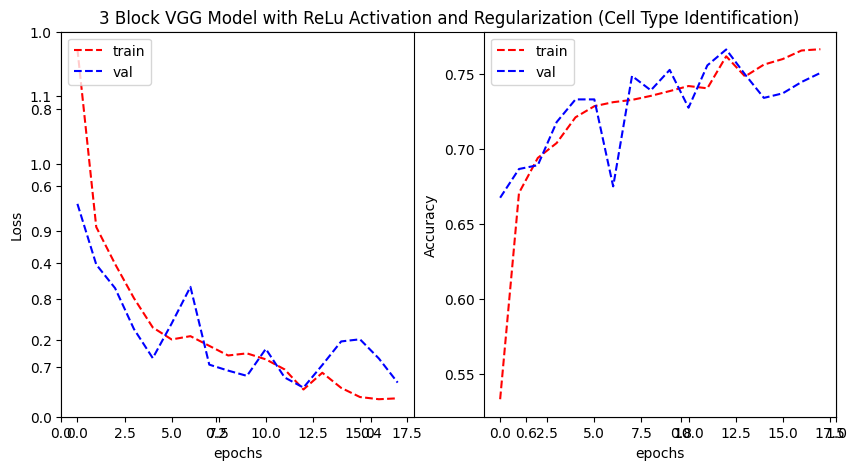

In [63]:
history_VGG_2 = model_VGG_2.fit(train_generator, validation_data = validation_generator, epochs=25, callbacks=earlyStop, verbose=1)

plot_learning_curve("3 Block VGG Model with ReLu Activation and Regularization (Cell Type Identification)", history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['categorical_accuracy'], history_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

Significantly better results just with regularization, will try to fit better later

In [64]:
#Using extra data to  improve the cell type classification
extra_data_for_type = data_extra[["InstanceID", "patientID", "ImageName"]]

def preprocess_image(filename, img_dir="./patch_images/"):
    path = os.path.join(img_dir, filename)
    image = Image.open(path).convert("RGB")
    image = image.resize((27, 27))
    image_array = np.array(image).astype(np.float32) / 255.0
    return image_array

X_extra = np.array([
    preprocess_image(name) for name in extra_data_for_type["ImageName"]
])

predictions = model_VGG_2.predict(X_extra)
predicted_classes = np.argmax(predictions, axis=1)

label_dict = {0: 'fibroblast', 1: 'lymphocyte', 2: 'neutrophil', 3: 'monocyte'}
predicted_labels = [label_dict[i] for i in predicted_classes]

extra_data_for_type["predicted_cellType"] = predicted_labels

extra_data_for_type.to_csv("extra_data_with_predictions.csv", index=False)

325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
